# Goal

The idea of this notebook is to correct the drift the image in order to be able to quantify the image better. Also I want a visual display of the drift

## Import the necessary packages

In [1]:
import skimage
import napari
from tifffile import imread,imwrite
from pathlib import Path
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import skimage.measure as sm
import seaborn as sns
import os
from scipy.optimize import curve_fit
from skimage.measure import label, regionprops, regionprops_table
from scipy import ndimage
from matplotlib import animation
from IPython.display import HTML
import matplotlib as cm
from skimage.segmentation import morphological_chan_vese,checkerboard_level_set
from skimage.filters import rank,gaussian
from skimage.morphology import disk
from skimage import exposure
from skimage import img_as_float
from matplotlib.patches import Circle
from scipy.optimize import linear_sum_assignment
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import min_weight_full_bipartite_matching
import scipy.stats
#from numba import jit

### Load a "raw image"

In [ ]:
path = Path('../data/tricho_wound.tif')
im = imread(path)[700:800,...].astype('uint16')
print(np.shape(im))

In [5]:
mask = imread('../data/results/chan_vese/placozoan-movie_wound_masked_chanvese.tif')[700:800,...]

In [ ]:
plt.imshow(segm_alg(new_image))

### I'm using the frames 718 to 748 because it's where there is drift

In [12]:
img = im[18:46,...]
ma = mask[18:46,...]

In [13]:
n = alg(img,ma)

In [ ]:
np.shape(n)

### Plotting the results

In [ ]:
for i in range(np.shape(n)[0]):
    plt.imshow(n[i,...])
    plt.title(f'Frame {18+i}')
    plt.axis('off')
    plt.show()

From this we can get the position of all the algae plane per plane

### Making a gif for visualization

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(5, 5))
for a in ax:
    a.axis('off')
im = ax[0].imshow(n[0,...], interpolation='bilinear',animated = True)
over = ax[1].imshow(img[0,...], interpolation='bilinear')

fig.tight_layout()

def update(t):
    im.set_data(A_anim[t,...])
    over.set_data(A_anim_2[t,...])
    for a in ax:
        a.set_title(f'Frame {718+t}')
    return [im,over]


nb_times_im = np.shape(n)[0]

A_anim = n[::n.shape[0]//nb_times_im ,...]
A_anim_2 = img[::img.shape[0]//nb_times_im ,...]

anim = animation.FuncAnimation(fig, update,
                               frames=nb_times_im, interval=50, 
                               blit=True)
HTML(anim.to_jshtml())

In [ ]:
f = r"../data/results/figures/drift_correction/animation_drift.gif" 
writergif = animation.PillowWriter(fps=1) 
anim.save(f, writer=writergif)

#### Compute the distance between the 2 (euclidian)

In [3]:
#@jit
def dist(points):
    one = pos_1.iloc[points[0]]
    two = pos_2.iloc[points[1]]

    diff = (two['centroid-1']-one['centroid-1'])**2 + (two['centroid-0']-one['centroid-0'])**2
    dist = np.sqrt(diff)
    #print(f'The image moved {dist:.2f} pixels up')
    return dist    

In [ ]:
po = [[131,125],[78,74],[67,66]]
d = []

for point in po:
    d.append(dist(point))

In [ ]:
print(f'The image moved up with a drift of {np.mean(d):.2f} pixels with an error of {np.std(d):.2f} pixels')

In [ ]:
cost = np.array([[4, 1, 3], [2, 0, 5], [3, 2, 2]])
cost

In [ ]:
col = [131,78,67]
row = [125,66,74]
m = []

for i in row:
    for j in col:
        print(i,j)
        m.append(dist([j,i]))
        
m = np.asarray(m).reshape((3,3))

In [ ]:
m

In [ ]:
row_ind, col_ind = linear_sum_assignment(m)

print(row_ind)
print(col_ind)

The assignment works. Now we need a way to compute the optimal distances from the results of the assignment

In [ ]:
for i,j in zip(row_ind,col_ind):
    print(row[i],col[j])

In [ ]:
biadjacency_matrix = csr_matrix(m)

In [ ]:
print(min_weight_full_bipartite_matching(biadjacency_matrix))

Now we need a way to do the same operation for all points.And it needs to work for images that don't have the same number of points...

For that I will try:
- The linear sum assignment
- The min weight full bipartite matching

In [ ]:
col = pos_2.index.values
row = pos_1.index.values
m = []

#'''
for i in row:
    for j in col:
        #print(i,j)
        m.append(dist([i,j]))
        
m = np.asarray(m).reshape((len(row),len(col)))

#'''

print(m.shape)

In [ ]:
row_ind, col_ind = linear_sum_assignment(m)

print(row_ind)
print(col_ind)

In [ ]:
biadjacency_matrix = csr_matrix(m)
r,c = min_weight_full_bipartite_matching(biadjacency_matrix)

In [ ]:
d_1 = []
for i,j in zip(r,c):
    d_1.append(dist([row[i],col[j]]))
    
print(np.mean(d_1))
print(np.std(d_1))

In [ ]:
d_2 = []
for i,j in zip(row_ind,col_ind):
    d_2.append(dist([row[i],col[j]]))
    
print(np.mean(d_2))
print(np.std(d_2))

Few observations:
- The two methods yield similar results
- The average drift is the same as when I computed between 3 relevant points (even if the sd is bigger) so it averages out
- the assignment is only keeping the lowest number of point (dimention of the matrix) so some points are not assigned and thus the assignment is not perfect hence a big sd...
- With this method I only compute the absolute value of the drift (because I'm taking the eucledian distance)
- If I want the direction of the distance I would need another measure ...

Let's make a function that computes everything all together

In [15]:
def dist(points):
    one = pos_1.iloc[points[0]]
    two = pos_2.iloc[points[1]]

    diff = (two['centroid-1']-one['centroid-1'])**2 + (two['centroid-0']-one['centroid-0'])**2
    dist = np.sqrt(diff)
    #print(f'The image moved {dist:.2f} pixels up')
    return dist 

def drift(row,col,method = 'linear'):
    '''
    Function to compute the drift between 2 time points.
    Workflow:
        - Create the distance matrix i.e. the "distance" between every point
        - perform linear sum assignment on this matrix
        - extract the best assignment and compute the 'optimal distance' between the assigned points    
    '''
    #Initialize the cost matrix
    m = []

    for t in row:
        for t_1 in col:
            m.append(dist([t,t_1])) #note that here the order of the arguments in the dist function matters 

    #reshape the matrix (might be a more efficient way to create it)
    
    m = np.asarray(m).reshape((len(row),len(col)))
    
    if method.lower() == 'linear':
        
        # Perform linear sum assignment

        row_ind, col_ind = linear_sum_assignment(m)
        
    elif method.lower() == 'bipartite':
        biadjacency_matrix = csr_matrix(m)
        
        row_ind,col_ind = min_weight_full_bipartite_matching(biadjacency_matrix)
   
    else:
        return 'Please input a valid method'
    
    # Initialize the optimal distance list
    
    distance = []
    
    # Besed on the result of the linear assignment compute it
    
    for i,j in zip(row_ind,col_ind):
        distance.append(dist([row[i],col[j]]))
        
    return distance

In [ ]:
f = drift(pos_1.index.values,pos_2.index.values,'linear')

print(np.mean(f))
print(np.std(f))

In [ ]:
f = drift(pos_1.index.values,pos_2.index.values,'bipartite')

print(np.mean(f))
print(np.std(f))

Compute the drift for more planes 

In [2]:
def eucldist(df_t,df_t1,points):
    one = df_t.iloc[points[0]]
    two = df_t1.iloc[points[1]]

    diff = (two['centroid-1']-one['centroid-1'])**2 + (two['centroid-0']-one['centroid-0'])**2
    dist = np.sqrt(diff)
    #print(f'The image moved {dist:.2f} pixels up')
    return dist 


def drift(df_t,df_t1,method = 'linear'):
    '''
    Function to compute the drift between 2 time points.
    Workflow:
        - Create the distance matrix i.e. the "distance" between every point
        - perform linear sum assignment on this matrix
        - extract the best assignment and compute the 'optimal distance' between the assigned points 
        
    Input: 
        - The 2 dataframes containing the position of all the algae for the 2 planes
        - the method to assign the objects default: linear
    '''
    #Initialize the cost matrix
    m = []
    
    row = df_t.index.values
    col = df_t1.index.values
    
    for t in row:
        for t_1 in col:
            m.append(eucldist(df_t,df_t1,[t,t_1])) #note that here the order of the arguments in the dist function matters 
            #m.append(entropy(df_t.iloc[row],df_t1.iloc[col]))
            
    #reshape the matrix (might be a more efficient way to create it)
    
    m = np.asarray(m).reshape((len(row),len(col)))
    
    if method.lower() == 'linear':
        
        # Perform linear sum assignment

        row_ind, col_ind = linear_sum_assignment(m)
        
    elif method.lower() == 'bipartite':
        
        biadjacency_matrix = csr_matrix(m)
        
        row_ind,col_ind = min_weight_full_bipartite_matching(biadjacency_matrix)
   
    else:
        return 'Please input a valid method'
    
    # Initialize the optimal distance list
    
    distance = []
    
    # Besed on the result of the linear assignment compute it
    
    for i,j in zip(row_ind,col_ind):
        distance.append(eucldist(df_t,df_t1,[row[i],col[j]]))
        
    return distance

def global_drift(im,method = 'linear'):
    
    '''
    Function to compute the drift for a whole image plane per plane
    Workflow:
        - Loop over planes
        - compute the labels for the 2 images
        - call the drift computation function to extract the mean drift between plane t and t+1
        - append the mean drift of all points to a list
    Inputs:
        - the mask_image of all the algae for each time point
        - the method to map the points between 2 time points
    '''

    drif = []
    
    for plane in range(np.shape(im)[0]-1):
        
        print(plane)
        
        lab = label(im[plane,...])
        props = regionprops_table(label_image=lab, properties=('centroid','area'))
        df_t = pd.DataFrame(props)
        
        # Filter the results to have plausible algae 
        # Here I am assuming that a "real algae" needs to have an area moe than 10 pixels² and less than 300
        
        df_t = df_t[df_t.area < 300].reset_index() #reset index to avoid having gaps in index value 
                                                #(it is used in the dist function)
        df_t = df_t[df_t.area > 10].reset_index()
        
        lab = label(im[plane+1,...])
        props = regionprops_table(label_image=lab, properties=('centroid','area'))
        df_t1 = pd.DataFrame(props) 
        df_t1 = df_t1[df_t1.area < 300].reset_index()
        df_t1 = df_t1[df_t1.area > 10].reset_index()
        
        
        drif.append(np.median(drift(df_t,df_t1,method)))
        
    return drif

In [3]:
import time

start = time.time()
test = imread('../data/tricho_wound_alg_only_otsu.tif')

drif = global_drift(test)

end = time.time() - start

print(f'This took: {end/60:.2f} minutes')
print(drif)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [54]:
#test = n[10:15,...].copy()

dri = global_drift(test,'bipartite')

print(dri)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

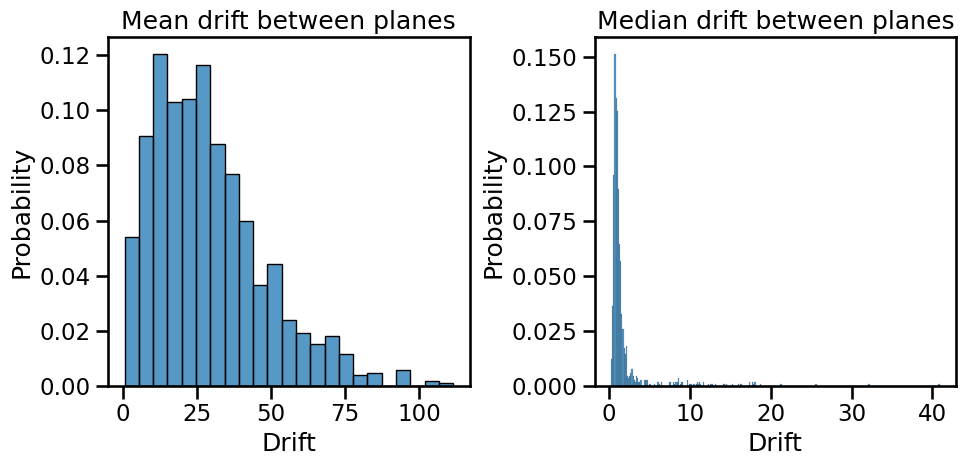

In [156]:
sns.set_context('talk')
sns.color_palette('colorblind')
fig,ax = plt.subplots(1,2,figsize=(10,5))

sns.histplot(drif,stat="probability",ax = ax[1])
sns.histplot(dri,stat="probability",ax = ax[0])

titles = ['Mean drift between planes', 'Median drift between planes']
for i,ax in enumerate(ax):
    ax.set_title(titles[i])
    ax.set_xlabel('Drift')
    
plt.tight_layout()
#plt.savefig('../data/results/figures/compare/full_pipeline/drift_distrib.png',dpi=300)
plt.show()

In [4]:
# Find the planes where the drift criteria is met
l = []
li = []
leng = 4 # length criteria

# loop over planes 
for c,i in enumerate(drif):
    
    #first criteria: is drift superio to 5 pixels if so append it to a list
    if i > 5:
        l.append(i)
        
        # if the previous criteria is met 5 times then there is drift
        
        if len(l) > leng:
            print(f'There is drift at between frame {c - leng+1} and {c}!')
            li.append(c - leng+1) # append the first plane where there is drift to a list for later
            
    else:
        #reset the list if the planes don't match the criteria
        l = []
        
li.append(0) # append a 0 to the list for the next step

There is drift at between frame 724 and 727!
There is drift at between frame 725 and 728!
There is drift at between frame 726 and 729!
There is drift at between frame 727 and 730!
There is drift at between frame 728 and 731!
There is drift at between frame 729 and 732!
There is drift at between frame 730 and 733!
There is drift at between frame 731 and 734!
There is drift at between frame 732 and 735!
There is drift at between frame 733 and 736!
There is drift at between frame 734 and 737!
There is drift at between frame 735 and 738!
There is drift at between frame 736 and 739!
There is drift at between frame 737 and 740!
There is drift at between frame 738 and 741!
There is drift at between frame 739 and 742!
There is drift at between frame 740 and 743!
There is drift at between frame 741 and 744!
There is drift at between frame 755 and 758!
There is drift at between frame 945 and 948!
There is drift at between frame 946 and 949!
There is drift at between frame 947 and 950!
There is d

In [5]:
# Get the interval in which there is a drift

start =  li[0]
end = 0
drift_pos = []

#loop over all planes where there was at least a drift of 5 for the next 5 planes
# the list looks like: 1,2,3,4,100,101,102,...
# We can make a condition that if the number n+1 in the list is not equal to the n number than the interval is n_0 to n

for i in range(1,len(li)):
    

    if li[i] != li[i-1] + 1:
        
        drift_pos.append([start,end])
        
        print([start,end])
        
        start = li[i]
    
    #we need to reset the end after the interval was found, to find more intervals
    
    end = li[i]+(leng-1)  
    
print(drift_pos)

[724, 744]
[755, 758]
[945, 964]
[973, 976]
[[724, 744], [755, 758], [945, 964], [973, 976]]


In [6]:
planes = [[x,x+1] for x in range(len(drif))]

crit = [x >5 for x in drif]

#print(planes)
df = pd.DataFrame([planes,drif,crit]).T
df.rename(columns = {0:'Planes',1:'Drift',2:'Color'},inplace = True)

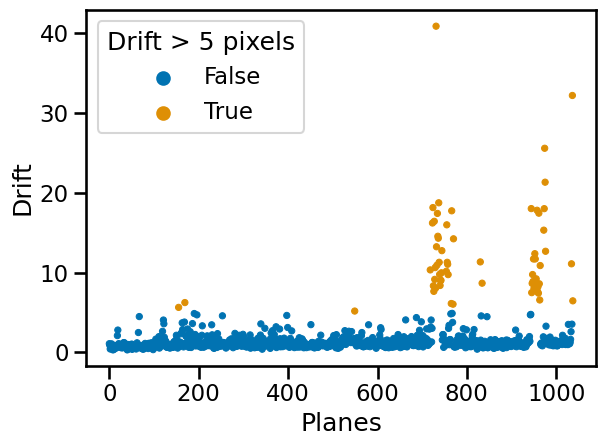

In [7]:
sns.set_context('talk')
sns.color_palette('colorblind')

sns.scatterplot(x = df.index.values ,y = 'Drift',data = df,marker='.',hue='Color',palette='colorblind',edgecolor=None)
plt.legend(title = 'Drift > 5 pixels')
plt.xlabel('Planes')
plt.tight_layout()
#plt.savefig('../data/results/figures/compare/full_pipeline/drift_criteria.png',dpi=300)
plt.show()

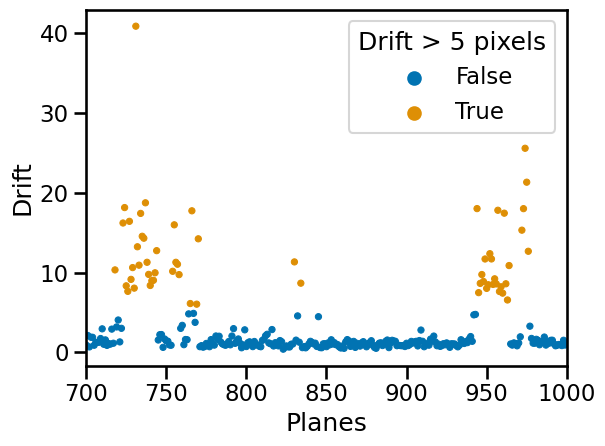

In [8]:
sns.set_context('talk')
sns.color_palette('colorblind')

sns.scatterplot(x = df.index.values ,y = 'Drift',data = df,marker='.',hue='Color',palette='colorblind',edgecolor=None)
plt.legend(title = 'Drift > 5 pixels')
plt.xlabel('Planes')
plt.xlim(700,1000)
plt.tight_layout()
#plt.savefig('../data/results/figures/compare/full_pipeline/drift_criteria_zoomed.png',dpi=300)
plt.show()

## Error measurement on the drift

In [9]:
df

,Planes,Drift,Color
0,"[0, 1]",1.080835,False
1,"[1, 2]",0.886515,False
2,"[2, 3]",0.417279,False
3,"[3, 4]",0.685486,False
4,"[4, 5]",0.479841,False
...,...,...,...
1033,"[1033, 1034]",2.586804,False
1034,"[1034, 1035]",11.093236,True
1035,"[1035, 1036]",3.529726,False
1036,"[1036, 1037]",32.191924,True


In [10]:
drift_pos

[[724, 744], [755, 758], [945, 964], [973, 976]]

In [11]:
couple = []
for i in drift_pos:
    j = i[0]
    while j != i[1]:
        couple.append([j,j+1])
        j+=1

In [13]:
df1 = df[df['Planes'].isin(couple)]
df1.reset_index(inplace=True)
df1

,index,Planes,Drift,Color
0,724,"[724, 725]",18.141486,True
1,725,"[725, 726]",8.333216,True
2,726,"[726, 727]",7.641506,True
3,727,"[727, 728]",16.418585,True
4,728,"[728, 729]",9.143074,True
5,729,"[729, 730]",10.619457,True
6,730,"[730, 731]",8.044139,True
7,731,"[731, 732]",40.876416,True
8,732,"[732, 733]",13.229273,True
9,733,"[733, 734]",10.921568,True


In [14]:
real_dist = []
path = ['724_744','755-758','945-964','973-976']
for i in path:
    e = pd.read_csv('../data/'+i+'.csv')
    e = e[['Y','X']]
    for j in range(len(e.index)-1):
        real_dist.append(eucldistance(e,[j,(j+1)]))
    print(len(real_dist))
len(real_dist)

20
23
42
45


45

In [15]:
df1['Real_distance'] = real_dist
df1.head()

C:\Users\nessl\AppData\Local\Temp\ipykernel_18000\3400783521.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['Real_distance'] = real_dist


,index,Planes,Drift,Color,Real_distance
0,724,"[724, 725]",18.141486,True,6.000000
1,725,"[725, 726]",8.333216,True,6.082763
2,726,"[726, 727]",7.641506,True,7.071068
3,727,"[727, 728]",16.418585,True,7.000000
4,728,"[728, 729]",9.143074,True,5.099020


In [16]:
error = [np.abs(df1.iloc[x].Drift - df1.iloc[x].Real_distance) for x in range(len(df1.index))]
error

[12.141486168673257,
 2.250453691758559,
 0.5704383695889899,
 9.418585106801238,
 4.044054569745885,
 3.6194574163181077,
 1.011246445967389,
 33.876415735627454,
 4.983062076859055,
 2.675356539803701,
 8.355786910899777,
 5.489362542579521,
 3.2568241305444907,
 9.74041637291677,
 0.23888399821974815,
 0.5473968935068516,
 0.13070846607493536,
 0.9125264052920077,
 0.48458083401565055,
 1.422530748038536,
 11.507318829398152,
 1.2828956627181807,
 1.038530847232634,
 2.478035098434832,
 0.5779498978719602,
 1.748748891173335,
 2.7968648251022605,
 1.4999719771551874,
 0.7321303332740738,
 3.470605256873272,
 4.298573709212214,
 1.7023071548151893,
 0.5445693229976243,
 4.212538855984777,
 0.5745403085508318,
 10.804740862506112,
 0.6236365804479282,
 0.7873641275805188,
 2.030686014716278,
 10.439254320099437,
 0.9746930968458596,
 2.436829574949112,
 17.00621765091494,
 4.361789770187276,
 7.676606357280264]

In [17]:
df1['Error'] = error

df1

C:\Users\nessl\AppData\Local\Temp\ipykernel_18000\965785681.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['Error'] = error


,index,Planes,Drift,Color,Real_distance,Error
0,724,"[724, 725]",18.141486,True,6.000000,12.141486
1,725,"[725, 726]",8.333216,True,6.082763,2.250454
2,726,"[726, 727]",7.641506,True,7.071068,0.570438
3,727,"[727, 728]",16.418585,True,7.000000,9.418585
4,728,"[728, 729]",9.143074,True,5.099020,4.044055
5,729,"[729, 730]",10.619457,True,7.000000,3.619457
6,730,"[730, 731]",8.044139,True,9.055385,1.011246
7,731,"[731, 732]",40.876416,True,7.000000,33.876416
8,732,"[732, 733]",13.229273,True,8.246211,4.983062
9,733,"[733, 734]",10.921568,True,8.246211,2.675357


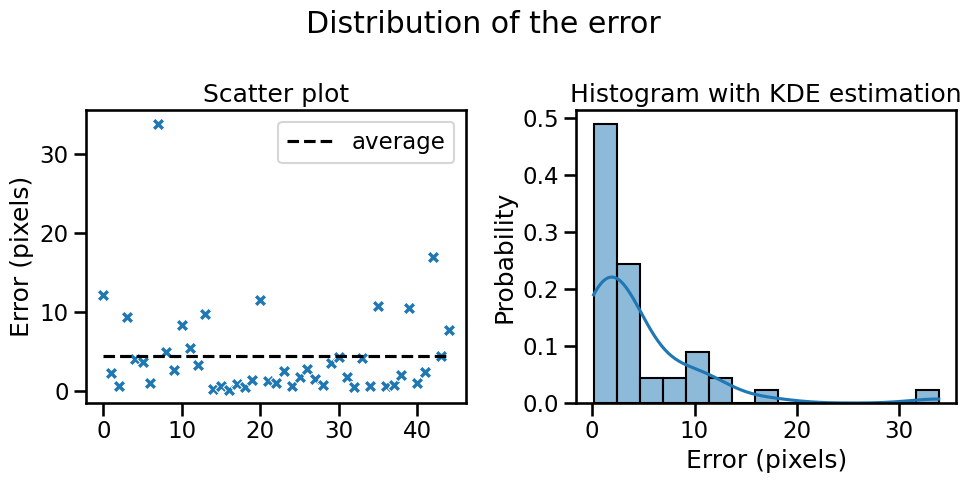

In [18]:
#sns.set_context("talk")
e = [x for x in error if x != max(error)]

fig ,ax = plt.subplots(1,2,figsize=(10,5))

sns.scatterplot(x =df1.index.values,y = df1.Error,marker='X',ax = ax[0])
ax[0].hlines(np.mean(df1.Error),min(df1.index.values),max(df1.index.values),linestyle='--',color='black',label='average')

sns.histplot(error,kde=True,stat='probability',ax=ax[1])

ax[0].set_ylabel('Error (pixels)')
ax[1].set_xlabel('Error (pixels)')

ax[0].legend()
fig.suptitle('Distribution of the error')
ax[0].set_title('Scatter plot')
ax[1].set_title('Histogram with KDE estimation')

plt.tight_layout()
#plt.savefig('../data/results/figures/compare/full_pipeline/distribution_error.png',dpi=300)

plt.show()

# Plot cummulative error and drift

In [19]:
er = [ x for x in error]

for i in range(4):
    er.append(0)


In [20]:
x = [x for x in range(len(drif))]
y = [0]
z = [0]
counter = 0

for i in range(1,len(drif)):
    if i in set(np.asarray(couple).flatten()):
        y.append(y[i-1]+drif[i])
        z.append(z[i-1]+er[counter])
        counter += 1
    else:
        y.append(y[i-1])
        z.append(z[i-1])

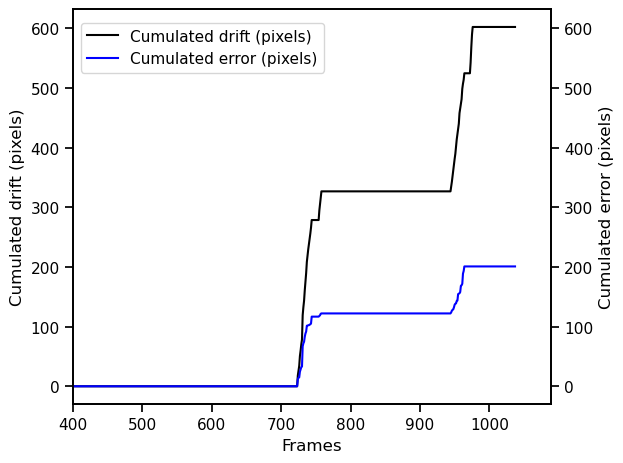

In [21]:
sns.set_context('notebook')
fig, ax = plt.subplots()

ax.plot( x,  y,color="black",label = 'Cumulated drift (pixels)')

ax2 = ax.twinx()
ax2.plot(x, z,color='blue',label='Cumulated error (pixels)')

ax.set_ylabel('Cumulated drift (pixels)')

ax.set_xlabel('Frames')
ax2.set_ylabel('Cumulated error (pixels)')

ax2.set_ylim(ax.get_ylim())

ax.set_xlim(400,max(ax.get_xlim()))
    
fig.legend(bbox_to_anchor=(0.53, 0.95))
plt.tight_layout()
#plt.savefig('../data/results/figures/compare/full_pipeline/cumulated_drift.png',dpi=300)
plt.show()

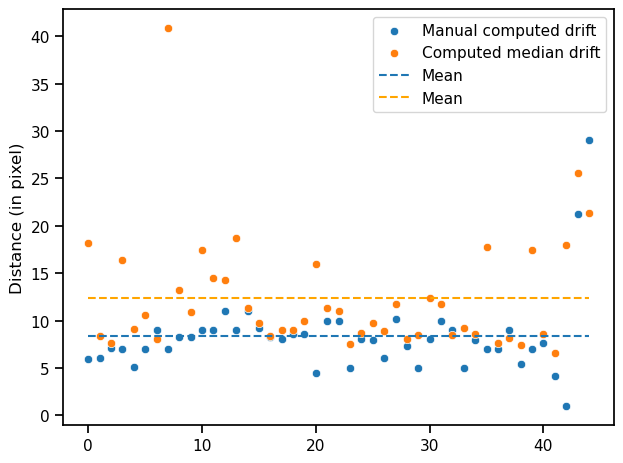

In [22]:
sns.set_context('notebook')
sns.scatterplot(x=df1.index,y=df1.Real_distance)
sns.scatterplot(x=df1.index,y=df1.Drift)
plt.hlines(np.mean(df1.Real_distance),min(df1.index),max(df1.index),linestyle='--')
plt.hlines(np.mean(df1.Drift),min(df1.index),max(df1.index),linestyle='--',color='orange')
plt.ylabel('Distance (in pixel)')
plt.legend(['Manual computed drift','Computed median drift','Mean','Mean'])
plt.tight_layout()
#plt.savefig('../data/results/figures/compare/full_pipeline/drift_error_scatter.png',dpi=300)


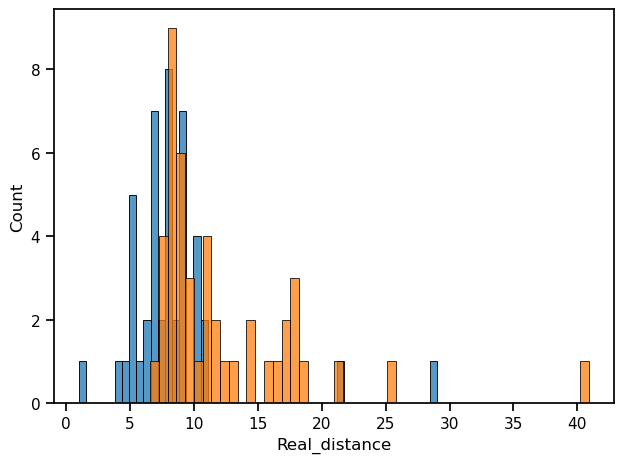

In [23]:
fig,ax = plt.subplots()

sp1 = sns.histplot(data=df1,x="Real_distance",bins=50,ax = ax)
sns.histplot(df1.Drift,bins=50,ax = ax,label="Drift")
plt.tight_layout()
#plt.savefig('../data/results/figures/compare/full_pipeline/drift_error_hist.png',dpi=300)

In [25]:
# Check wether the distributions are similar
# non parameteric because the distributions are not normal

g = scipy.stats.wilcoxon(df1.Drift.values,df1.Real_distance.values)

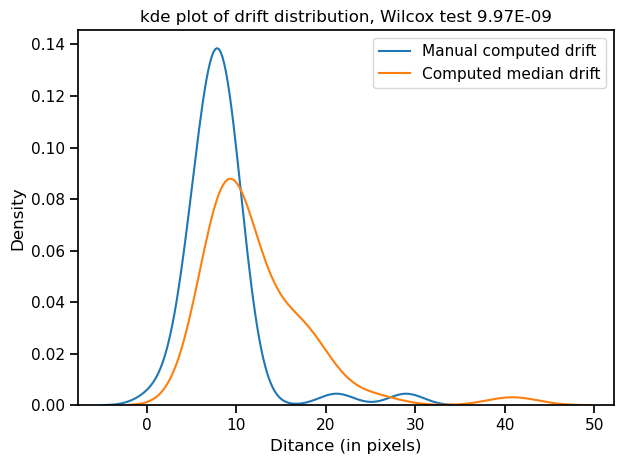

In [26]:
sns.set_context('notebook')

fig,ax = plt.subplots()

sns.kdeplot(df1.Real_distance,ax = ax,label='Manual computed drift')
sns.kdeplot(df1.Drift,ax = ax,label='Computed median drift')
plt.legend()
ax.set_xlabel('Ditance (in pixels)')
plt.title(f'kde plot of drift distribution, Wilcox test {g.pvalue:.2E}')
plt.tight_layout()
#plt.savefig('../data/results/figures/compare/full_pipeline/drift_error_kde.png',dpi=300)
plt.show()

In [27]:
scipy.stats.kstest(df1.Drift.values,df1.Real_distance.values)

KstestResult(statistic=0.4444444444444444, pvalue=0.0002237060786301627)

## Find where the error is maximum and plot the assignment

In [28]:
df_e = df1[df1.Error == max(df1.Error)]
df_e

,index,Planes,Drift,Color,Real_distance,Error
7,731,"[731, 732]",40.876416,True,7.0,33.876416


In [29]:
def drift(df_t,df_t1,method = 'linear'):
    '''
    Function to compute the drift between 2 time points.
    Workflow:
        - Create the distance matrix i.e. the "distance" between every point
        - perform linear sum assignment on this matrix
        - extract the best assignment and compute the 'optimal distance' between the assigned points 
        
    Input: 
        - The 2 dataframes containing the position of all the algae for the 2 planes
        - the method to assign the objects default: linear
    '''
    #Initialize the cost matrix
    m = []
    
    row = df_t.index.values
    col = df_t1.index.values
    
    for t in row:
        for t_1 in col:
            m.append(eucldist(df_t,df_t1,[t,t_1])) #note that here the order of the arguments in the dist function matters 
            #m.append(entropy(df_t.iloc[row],df_t1.iloc[col]))
            
    #reshape the matrix (might be a more efficient way to create it)
    
    m = np.asarray(m).reshape((len(row),len(col)))
    
    if method.lower() == 'linear':
        
        # Perform linear sum assignment

        row_ind, col_ind = linear_sum_assignment(m)
        
    elif method.lower() == 'bipartite':
        
        biadjacency_matrix = csr_matrix(m)
        
        row_ind,col_ind = min_weight_full_bipartite_matching(biadjacency_matrix)
   
    else:
        return 'Please input a valid method'
    
    # Initialize the optimal distance list
    
    distance = []
    
    # Besed on the result of the linear assignment compute it
    
    for i,j in zip(row_ind,col_ind):
        distance.append(eucldist(df_t,df_t1,[row[i],col[j]]))
        
    return row_ind,col_ind

In [30]:
test = imread('../data/tricho_wound_alg_only_otsu.tif')

In [31]:
im = test.copy()
plane = 731

lab = label(im[plane,...])
props = regionprops_table(label_image=lab, properties=('centroid','area'))
df_t = pd.DataFrame(props)

# Filter the results to have plausible algae 
# Here I am assuming that a "real algae" needs to have an area moe than 10 pixels² and less than 300

df_t = df_t[df_t.area < 300].reset_index() #reset index to avoid having gaps in index value 
                                        #(it is used in the dist function)
df_t = df_t[df_t.area > 10].reset_index()

lab = label(im[plane+1,...])
props = regionprops_table(label_image=lab, properties=('centroid','area'))
df_t1 = pd.DataFrame(props) 
df_t1 = df_t1[df_t1.area < 300].reset_index()
df_t1 = df_t1[df_t1.area > 10].reset_index()

In [32]:
e = drift(df_t,df_t1)

In [33]:
row = df_t.index.values
col = df_t1.index.values

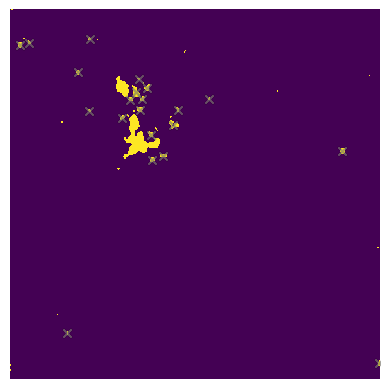

In [34]:
for i in df_t.index:
    plt.scatter(df_t['centroid-1'],df_t['centroid-0'],marker='x',alpha=0.05)

plt.imshow(test[731,...],interpolation='nearest')
plt.axis('off')
plt.show()

In [35]:
df_t['match'] = [x for x in np.zeros(len(df_t.index),dtype=int)]

df_t

,level_0,index,centroid-0,centroid-1,area,match
0,2,2,46.000000,123.500000,16,0
1,5,5,51.380952,29.095238,21,0
2,6,6,54.790698,14.953488,43,0
3,8,8,97.818182,105.696970,33,0
4,10,11,108.083333,200.166667,12,0
5,13,14,121.934426,213.491803,61,0
6,14,15,128.763514,195.324324,148,0
7,16,17,139.590909,205.704545,44,0
8,17,18,139.951220,187.268293,41,0
9,18,19,139.000000,309.833333,12,0


In [36]:
for i,j in zip(e[0],e[1]):
    df_t['match'].iloc[i] = j 
    
df_t.head()

C:\Users\nessl\AppData\Local\Temp\ipykernel_18000\1998580886.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_t['match'].iloc[i] = j


,level_0,index,centroid-0,centroid-1,area,match
0,2,2,46.000000,123.500000,16,2
1,5,5,51.380952,29.095238,21,0
2,6,6,54.790698,14.953488,43,1
3,8,8,97.818182,105.696970,33,3
4,10,11,108.083333,200.166667,12,4


In [37]:
df_t = df_t[df_t.match != 0]

In [38]:
df_t1['index'] = [x for x in range(len(df_t1.index.values))]
df_t1

,level_0,index,centroid-0,centroid-1,area
0,2,0,10.666667,555.533333,15
1,10,1,44.072727,11.927273,55
2,11,2,64.571429,156.085714,35
3,13,3,98.464789,106.619718,71
4,14,4,108.820225,207.039326,178
5,18,5,149.235294,261.500000,34
6,20,6,161.288889,250.200000,45
7,21,7,167.117647,80.588235,17
8,22,8,172.767442,252.744186,43
9,23,9,187.000000,219.666667,18


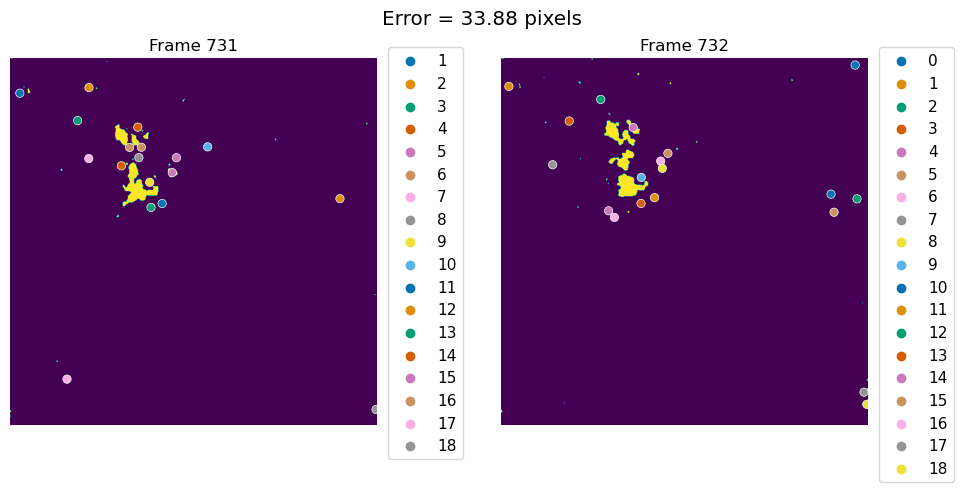

In [39]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(test[731,...])
sns.scatterplot(data=df_t,x='centroid-1',y='centroid-0',hue='match',palette='colorblind',ax=ax[0])
ax[0].legend(bbox_to_anchor=(1.01, 1.05))
ax[0].set_title('Frame 731')

ax[1].imshow(test[732,...])
sns.scatterplot(data=df_t1,x='centroid-1',y='centroid-0',hue='index',palette='colorblind',ax=ax[1])
ax[1].legend(bbox_to_anchor=(1.01, 1.05))
ax[1].set_title('Frame 732')


for ax in ax:
    ax.axis('off')
    
fig.suptitle(f'Error = {df_e.Error.values[0]:.2f} pixels')
plt.tight_layout()
#plt.savefig('../data/results/figures/compare/full_pipeline/drift_error_visual.png',dpi=300)
plt.show()

## Find the direction of the drift

In [4]:
def dist(df_t,df_t1,points):
    one = df_t.iloc[points[0]]
    two = df_t1.iloc[points[1]]

    dx = (two['centroid-1']-one['centroid-1'])
    dy = (two['centroid-0']-one['centroid-0'])
    
    return [dx,dy] 

def eucldist(df_t,df_t1,points):
    one = df_t.iloc[points[0]]
    two = df_t1.iloc[points[1]]

    diff = (two['centroid-1']-one['centroid-1'])**2 + (two['centroid-0']-one['centroid-0'])**2
    dist = np.sqrt(diff)
    #print(f'The image moved {dist:.2f} pixels up')
    return dist 

def drift(df_t,df_t1,method = 'linear'):
    '''
    Function to compute the drift between 2 time points.
    Workflow:
        - Create the distance matrix i.e. the "distance" between every point
        - perform linear sum assignment on this matrix
        - extract the best assignment and compute the 'optimal distance' between the assigned points 
        
    Input: 
        - The 2 dataframes containing the position of all the algae for the 2 planes
        - the method to assign the objects default: linear
    '''
    #Initialize the cost matrix
    m = []
    
    row = df_t.index.values
    col = df_t1.index.values
    
    for t in row:
        for t_1 in col:
            m.append(eucldist(df_t,df_t1,[t,t_1])) #note that here the order of the arguments in the dist function matters 
            
    #reshape the matrix (might be a more efficient way to create it)
    
    m = np.asarray(m).reshape((len(row),len(col)))
    
    if method.lower() == 'linear':
        
        # Perform linear sum assignment

        row_ind, col_ind = linear_sum_assignment(m)
        
    elif method.lower() == 'bipartite':
        
        biadjacency_matrix = csr_matrix(m)
        
        row_ind,col_ind = min_weight_full_bipartite_matching(biadjacency_matrix)
   
    else:
        return 'Please input a valid method'
    
    # Initialize the optimal distance list
    
    distance = []
    
    # Besed on the result of the linear assignment compute it
    
    for i,j in zip(row_ind,col_ind):
        distance.append(dist(df_t,df_t1,[row[i],col[j]]))
        
    return distance

def global_drift(im,method = 'linear'):
    
    '''
    Function to compute the drift for a whole image plane per plane
    Workflow:
        - Loop over planes
        - compute the labels for the 2 images
        - call the drift computation function to extract the mean drift between plane t and t+1
        - append the mean drift of all points to a list
    Inputs:
        - the mask_image of all the algae for each time point
        - the method to map the points between 2 time points
    '''

    drifx = []
    drify = []
    
    for plane in range(np.shape(im)[0]-1):
        
        print(plane)
        
        lab = label(im[plane,...])
        props = regionprops_table(label_image=lab, properties=('centroid','area'))
        df_t = pd.DataFrame(props)
        
        # Filter the results to have plausible algae 
        # Here I am assuming that a "real algae" needs to have an area moe than 10 pixels² and less than 300
        
        df_t = df_t[df_t.area < 300].reset_index() #reset index to avoid having gaps in index value 
                                                #(it is used in the dist function)
        df_t = df_t[df_t.area > 10].reset_index()
        
        lab = label(im[plane+1,...])
        props = regionprops_table(label_image=lab, properties=('centroid','area'))
        df_t1 = pd.DataFrame(props) 
        df_t1 = df_t1[df_t1.area < 300].reset_index()
        df_t1 = df_t1[df_t1.area > 10].reset_index()
        
        e = drift(df_t,df_t1,method)
        x = [x[0] for x in e]
        y = [x[1] for x in e]
        
        drifx.append(np.median(x))
        drify.append(np.median(y))
        
    return [drifx,drify]

In [5]:
test = imread('../data/new_movie_alg_only_otsu.tif')

driftcomb = global_drift(test)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [6]:
dx = driftcomb[0]
dy = driftcomb[1]

In [7]:
'''
Find where there is drift:
    - the criteria is that over the last 4 frames the median displacement is >3 (absolute value)
    - I use the media to avoid getting biased by planes where the pipeline failed

Workflow:
- Create a list with 3 zeros
- Loop over all values of drift in x and y
- append to the 0 list the absolute value of the drift
- If the median of the n-4 n frame is > 3 pixels than there is drift
    - in that case I look at the mean of the distance in those planes
    - The sign of this will give me the direction
- I append to another list:
    -the start plane of the drift
    -the end plane of the drift
    - the direction
    - if it's in x or y
    - the median of the displacement
'''
lx = [0,0,0]
ly = [0,0,0]

lix = []
liy = []

counterx = 4
countery = 4

n = 0
direc = []
# loop over planes

for i in dx:
    #'''
    lx.append(np.abs(i))
    ly.append(np.abs(dy[countery-4]))
    
    if np.median(lx[counterx-4:counterx]) > 3 :
        
        if np.mean(dx[counterx-4:counterx]) < 0:
            n = 'negative'
            direc.append([counterx-4,counterx,1,'x',np.median(lx[counterx-4:counterx])])
        else: 
            direc.append([counterx-4,counterx,0,'x',np.median(lx[counterx-4:counterx])])
            n = 'positive'
            
        print(f'There is a {n} drift in x at between frame {counterx-4} and {counterx}!')
        
        #print(dx[counterx-4:counterx])
        
        #break
        
        lix.append(counterx-4)# append the first plane where there is drift to a list for later    

    if np.median(ly[countery-4:countery]) > 3:
        
        if np.mean(dy[countery-4:countery]) < 0:
            n = 'negative'
            direc.append([countery-4,countery,1,'y',np.median(ly[countery-4:countery])])
        else:
            n = 'positive'
            direc.append([countery-4,countery,0,'y',np.median(ly[countery-4:countery])])
            
        print(f'There is a {n} drift in y at between frame {countery-4} and {countery}!')
        liy.append(countery-4)
           
    counterx += 1 
    countery += 1
    
   #'''

lix.append(0)# append a 0 to the list for the next step
liy.append(0)

There is a positive drift in y at between frame 88 and 92!
There is a positive drift in y at between frame 91 and 95!
There is a positive drift in x at between frame 232 and 236!
There is a positive drift in x at between frame 233 and 237!
There is a positive drift in x at between frame 234 and 238!
There is a positive drift in x at between frame 235 and 239!
There is a positive drift in x at between frame 236 and 240!
There is a positive drift in x at between frame 257 and 261!
There is a positive drift in x at between frame 258 and 262!
There is a negative drift in x at between frame 259 and 263!
There is a positive drift in y at between frame 367 and 371!
There is a positive drift in y at between frame 403 and 407!
There is a positive drift in y at between frame 404 and 408!
There is a positive drift in y at between frame 405 and 409!
There is a positive drift in y at between frame 406 and 410!
There is a positive drift in y at between frame 407 and 411!
There is a positive drift in

In [8]:
start =  direc[0][0]
end = 0
drift_pos = []
ampl = 0
#loop over all planes where there was at least a drift
# the list looks like: 1,2,3,4,100,101,102,...
# We can make a condition that if the number n+1 in the list is not equal to the n number than the interval is n_0 to n

for i in range(1,len(st)):
    
    ampl += direc[i-1][4]
    
    if st[i] != st[i-1] + 1:
        #print(direc[i])
        #print(direc[i-1])
        #break
        drift_pos.append([start,end,direc[i-1][2],direc[i-1][3],ampl])
        
        print([start,end])
        
        start = st[i]
        ampl = 0
    
    #we need to reset the end after the interval was found, to find more intervals
    
    end = st[i]+(4)  
    
print(drift_pos)

NameError: name 'st' is not defined

In [194]:
st = [direc[x][0] for x in range(len(direc))]
st.append(0)

In [195]:
direc.append([0,0,0,0])

In [9]:
direc

[[88, 92, 0, 'y', 3.69822518370907],
 [91, 95, 0, 'y', 6.007777054162588],
 [232, 236, 0, 'x', 5.930975371897489],
 [233, 237, 0, 'x', 10.943982059607066],
 [234, 238, 0, 'x', 10.943982059607066],
 [235, 239, 0, 'x', 13.717417876241399],
 [236, 240, 0, 'x', 9.449019607843127],
 [257, 261, 0, 'x', 6.827554798143041],
 [258, 262, 0, 'x', 6.813644688644715],
 [259, 263, 1, 'x', 6.813644688644715],
 [367, 371, 0, 'y', 4.622386672448969],
 [403, 407, 0, 'y', 3.193868689896556],
 [404, 408, 0, 'y', 3.193868689896556],
 [405, 409, 0, 'y', 3.1949375651270167],
 [406, 410, 0, 'y', 3.230815580068878],
 [407, 411, 0, 'y', 3.230815580068878],
 [408, 412, 0, 'y', 3.255546404799688],
 [409, 413, 0, 'y', 3.255546404799688],
 [467, 471, 0, 'y', 3.2208578701999855],
 [468, 472, 1, 'y', 3.2208578701999855],
 [469, 473, 1, 'y', 3.168209695709699],
 [479, 483, 0, 'x', 3.6194225836940745],
 [480, 484, 0, 'x', 3.8005984385183353],
 [481, 485, 0, 'x', 3.8005984385183353],
 [833, 837, 1, 'x', 5.03648399014778

In [279]:
df_driftg = pd.DataFrame(drift_pos,columns=['start_frame','end_frame','direction','coord','displacement'])
df_driftg

,start_frame,end_frame,direction,coord,displacement
0,725,740,1,y,62.930118
1,739,748,1,y,31.129803
2,757,764,0,x,17.250957
3,766,775,0,x,19.945145
4,945,968,1,y,114.195100
5,976,980,0,x,3.001876


In [280]:
dp = [[drift_pos[i][0],drift_pos[i][1]] for i in range(len(drift_pos))]

dp

[[725, 740], [739, 748], [757, 764], [766, 775], [945, 968], [976, 980]]

In [305]:
couple = []
for i in dp:
    j = i[0]
    while j != i[1]:
        couple.append([j,j+1])
        j+=1
        
couple

[[725, 726],
 [726, 727],
 [727, 728],
 [728, 729],
 [729, 730],
 [730, 731],
 [731, 732],
 [732, 733],
 [733, 734],
 [734, 735],
 [735, 736],
 [736, 737],
 [737, 738],
 [738, 739],
 [739, 740],
 [739, 740],
 [740, 741],
 [741, 742],
 [742, 743],
 [743, 744],
 [744, 745],
 [745, 746],
 [746, 747],
 [747, 748],
 [757, 758],
 [758, 759],
 [759, 760],
 [760, 761],
 [761, 762],
 [762, 763],
 [763, 764],
 [766, 767],
 [767, 768],
 [768, 769],
 [769, 770],
 [770, 771],
 [771, 772],
 [772, 773],
 [773, 774],
 [774, 775],
 [945, 946],
 [946, 947],
 [947, 948],
 [948, 949],
 [949, 950],
 [950, 951],
 [951, 952],
 [952, 953],
 [953, 954],
 [954, 955],
 [955, 956],
 [956, 957],
 [957, 958],
 [958, 959],
 [959, 960],
 [960, 961],
 [961, 962],
 [962, 963],
 [963, 964],
 [964, 965],
 [965, 966],
 [966, 967],
 [967, 968],
 [976, 977],
 [977, 978],
 [978, 979],
 [979, 980]]

In [282]:
planes = [[x,x+1] for x in range(len(dx))]

df_dr = pd.DataFrame([planes,dx,dy]).T

df_dr.rename(columns={0:"Plane",1:"drift_x",2:"drift_y"},inplace = True)

v = [df_dr.Plane.values[i] in couple for i in range(len(df_dr.Plane.values))] 

df_dr["drift?"] = v

df_dr

,Plane,drift_x,drift_y,drift?
0,"[0, 1]",-0.074339,-0.014358,False
1,"[1, 2]",0.101544,-0.863225,False
2,"[2, 3]",-0.003458,0.034091,False
3,"[3, 4]",-0.15,0.507937,False
4,"[4, 5]",0.144501,-0.036364,False
...,...,...,...,...
1033,"[1033, 1034]",0.163333,-1.439744,False
1034,"[1034, 1035]",1.028209,-1.513393,False
1035,"[1035, 1036]",-0.31022,-2.386387,False
1036,"[1036, 1037]",-0.259731,-25.891494,False


In [284]:
df_drift = df_dr[df_dr['drift?'] == True]
df_drift.drop(['drift?'],axis =1,inplace = True)
df_drift

C:\Users\nessl\AppData\Local\Temp\ipykernel_18000\4097794165.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_drift.drop(['drift?'],axis =1,inplace = True)


,Plane,drift_x,drift_y
725,"[725, 726]",0.166667,-4.752381
726,"[726, 727]",0.354932,-0.678327
727,"[727, 728]",-0.091589,-6.776887
728,"[728, 729]",0.153527,-4.676524
729,"[729, 730]",0.780979,-8.839052
...,...,...,...
967,"[967, 968]",0.072964,-0.209494
976,"[976, 977]",4.7756,2.947567
977,"[977, 978]",-0.481641,-0.689666
978,"[978, 979]",-0.919349,-0.029632


In [10]:
pos = []
for value in direc:
    start = value[0]
    end = value[1]

    while start != end:
        #'''
        if value[3] == 'y':
            pos.append([start,start+1,value[2],value[3],round(dy[start])])
        else:
            pos.append([start,start+1,value[2],value[3],round(dx[start])])
        #'''
        start += 1
        
pos

[[88, 89, 0, 'y', 11],
 [89, 90, 0, 'y', 0],
 [90, 91, 0, 'y', 1],
 [91, 92, 0, 'y', 11],
 [91, 92, 0, 'y', 11],
 [92, 93, 0, 'y', 0],
 [93, 94, 0, 'y', 0],
 [94, 95, 0, 'y', 0],
 [232, 233, 0, 'x', 13],
 [233, 234, 0, 'x', 15],
 [234, 235, 0, 'x', -1],
 [235, 236, 0, 'x', 16],
 [233, 234, 0, 'x', 15],
 [234, 235, 0, 'x', -1],
 [235, 236, 0, 'x', 16],
 [236, 237, 0, 'x', 4],
 [234, 235, 0, 'x', -1],
 [235, 236, 0, 'x', 16],
 [236, 237, 0, 'x', 4],
 [237, 238, 0, 'x', 0],
 [235, 236, 0, 'x', 16],
 [236, 237, 0, 'x', 4],
 [237, 238, 0, 'x', 0],
 [238, 239, 0, 'x', 0],
 [236, 237, 0, 'x', 4],
 [237, 238, 0, 'x', 0],
 [238, 239, 0, 'x', 0],
 [239, 240, 0, 'x', 0],
 [257, 258, 0, 'x', 14],
 [258, 259, 0, 'x', 0],
 [259, 260, 0, 'x', 0],
 [260, 261, 0, 'x', 0],
 [258, 259, 0, 'x', 0],
 [259, 260, 0, 'x', 0],
 [260, 261, 0, 'x', 0],
 [261, 262, 0, 'x', 0],
 [259, 260, 1, 'x', 0],
 [260, 261, 1, 'x', 0],
 [261, 262, 1, 'x', 0],
 [262, 263, 1, 'x', 0],
 [367, 368, 0, 'y', 9],
 [368, 369, 0, 'y'

In [11]:
res = []
single_drift = []
for j,i in enumerate(pos):
    if [i[0],i[1]] not in res:
        single_drift.append(i)
        res.append([i[0],i[1]])
        
        
single_drift

[[88, 89, 0, 'y', 11],
 [89, 90, 0, 'y', 0],
 [90, 91, 0, 'y', 1],
 [91, 92, 0, 'y', 11],
 [92, 93, 0, 'y', 0],
 [93, 94, 0, 'y', 0],
 [94, 95, 0, 'y', 0],
 [232, 233, 0, 'x', 13],
 [233, 234, 0, 'x', 15],
 [234, 235, 0, 'x', -1],
 [235, 236, 0, 'x', 16],
 [236, 237, 0, 'x', 4],
 [237, 238, 0, 'x', 0],
 [238, 239, 0, 'x', 0],
 [239, 240, 0, 'x', 0],
 [257, 258, 0, 'x', 14],
 [258, 259, 0, 'x', 0],
 [259, 260, 0, 'x', 0],
 [260, 261, 0, 'x', 0],
 [261, 262, 0, 'x', 0],
 [262, 263, 1, 'x', 0],
 [367, 368, 0, 'y', 9],
 [368, 369, 0, 'y', 0],
 [369, 370, 0, 'y', 0],
 [370, 371, 0, 'y', 0],
 [403, 404, 0, 'y', 18],
 [404, 405, 0, 'y', 0],
 [405, 406, 0, 'y', 0],
 [406, 407, 0, 'y', 6],
 [407, 408, 0, 'y', 12],
 [408, 409, 0, 'y', 0],
 [409, 410, 0, 'y', 0],
 [410, 411, 0, 'y', 0],
 [411, 412, 0, 'y', 12],
 [412, 413, 0, 'y', 0],
 [467, 468, 0, 'y', 6],
 [468, 469, 0, 'y', 0],
 [469, 470, 0, 'y', 0],
 [470, 471, 0, 'y', 0],
 [471, 472, 1, 'y', 0],
 [472, 473, 1, 'y', 0],
 [479, 480, 0, 'x', 

In [12]:
res

[[88, 89],
 [89, 90],
 [90, 91],
 [91, 92],
 [92, 93],
 [93, 94],
 [94, 95],
 [232, 233],
 [233, 234],
 [234, 235],
 [235, 236],
 [236, 237],
 [237, 238],
 [238, 239],
 [239, 240],
 [257, 258],
 [258, 259],
 [259, 260],
 [260, 261],
 [261, 262],
 [262, 263],
 [367, 368],
 [368, 369],
 [369, 370],
 [370, 371],
 [403, 404],
 [404, 405],
 [405, 406],
 [406, 407],
 [407, 408],
 [408, 409],
 [409, 410],
 [410, 411],
 [411, 412],
 [412, 413],
 [467, 468],
 [468, 469],
 [469, 470],
 [470, 471],
 [471, 472],
 [472, 473],
 [479, 480],
 [480, 481],
 [481, 482],
 [482, 483],
 [483, 484],
 [484, 485],
 [833, 834],
 [834, 835],
 [835, 836],
 [836, 837],
 [837, 838],
 [847, 848],
 [848, 849],
 [849, 850],
 [850, 851],
 [851, 852],
 [852, 853],
 [853, 854],
 [854, 855]]

In [13]:
df_drift = pd.DataFrame(single_drift,columns=(['start','end','direction','coord','displacement']))
df_drift

,start,end,direction,coord,displacement
0,88,89,0,y,11
1,89,90,0,y,0
2,90,91,0,y,1
3,91,92,0,y,11
4,92,93,0,y,0
5,93,94,0,y,0
6,94,95,0,y,0
7,232,233,0,x,13
8,233,234,0,x,15
9,234,235,0,x,-1


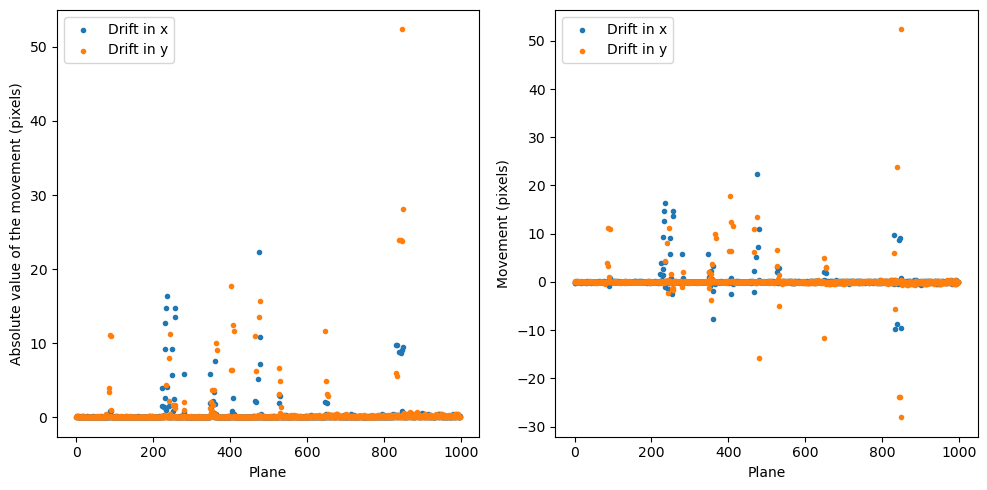

In [16]:
fig, ax = plt.subplots(1,2,figsize=(10,5))

ax[0].scatter([x for x in range(len(dx))],np.abs(dx),marker='.',label="Drift in x")
ax[0].scatter([x for x in range(len(dy))],np.abs(dy),marker='.',label = 'Drift in y')
ax[0].set_ylabel('Absolute value of the movement (pixels)')
ax[0].legend()

ax[1].scatter([x for x in range(len(dx))],dx,marker='.',label="Drift in x")
ax[1].scatter([x for x in range(len(dy))],dy,marker='.',label = 'Drift in y')
ax[1].set_ylabel('Movement (pixels)')
ax[1].legend()

for axi in ax:
    #axi.set_xlim(600,1050)
    axi.set_xlabel('Plane')

plt.tight_layout()

#plt.savefig('../data/results/figures/compare/full_pipeline/drift_xy.png',dpi=300)

In [17]:
direc[0]

[88, 92, 0, 'y', 3.69822518370907]

## Create the canva 

In [19]:
im = imread('../data/new_movie_1.tif')[0:1000,...]

In [20]:
orix = [0]
oriy = [0]

maxx = [np.shape(im)[1]-1]
maxy = [np.shape(im)[2]-1]

counterx = 1
countery = 1

for i in df_drift.iloc:
    if i.coord == 'x':
        if i.direction == 0:
            orix.append(orix[counterx-1] - np.abs(i.displacement))
            maxx.append(maxx[counterx-1] - np.abs(i.displacement))
        else:
            orix.append(orix[counterx-1] + np.abs(i.displacement))
            maxx.append(maxx[counterx-1] + np.abs(i.displacement))
            
        counterx +=1
    else:
        if i.direction == 0:
            oriy.append(oriy[countery-1] - np.abs(i.displacement))
            maxy.append(maxy[countery-1] - np.abs(i.displacement))
        else:
            oriy.append(oriy[countery-1] + np.abs(i.displacement))
            maxy.append(maxy[countery-1] + np.abs(i.displacement))
        countery += 1  

In [21]:
print(f'({min(orix)},{min(oriy)})')
print(f'({max(maxx)},{max(maxy)})')

(-84,-87)
(575,575)


In [104]:
path = Path('../data/tricho_wound.tif')
im = imread(path)
print(np.shape(im))

(1039, 576, 576)


In [22]:
lengx = np.abs(max(maxx)+1) + np.abs(min(orix)) + 1

lengy = np.abs(max(maxy)) + np.abs(min(oriy)) + 1 

In [32]:
canva = np.zeros((np.shape(im)[0],lengy,lengx))

In [33]:
diffx = lengx - np.shape(im[0])[0] 
diffy = lengy - np.shape(im[0])[1] 
print(diffx,diffy)

85 87


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

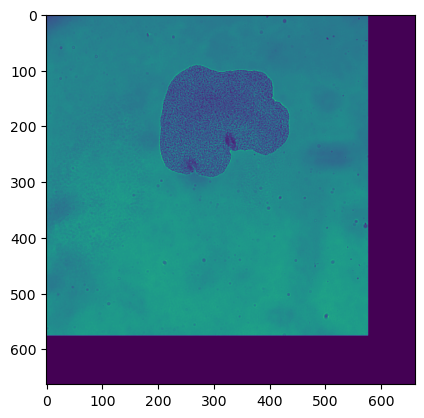

In [35]:
# Initialize the first frame:

ymin = diffy
ymax = np.shape(canva[0,...])[0]

xmin = diffx
xmax = np.shape(canva[0,...])[1]

canva[0,ymin:ymax,xmin:xmax] = im[0]

counter = 0

for plane in range(np.shape(im)[0]):
    print(plane)
    
    if [plane,plane+1] in res:
        
        i = df_drift.iloc[counter]
        counter +=1
        if i.coord == 'x':
            if i.direction == 0:
                xmin = xmin - np.abs(i.displacement)
                xmax = xmax - np.abs(i.displacement) 

                ymin = ymin 
                ymax = ymax 
                
                canva[plane,ymin:ymax,xmin:xmax] = im[i.start] 
                
            else:
                xmin = xmin + np.abs(i.displacement)
                xmax = xmax + np.abs(i.displacement)

                ymin = ymin
                ymax = ymax

                canva[plane,ymin:ymax,xmin:xmax] = im[i.start]
        else:
            if i.direction == 0:
                xmin = xmin 
                xmax = xmax 

                ymin = ymin - np.abs(i.displacement)
                ymax = ymax - np.abs(i.displacement)
                
                canva[plane,ymin:ymax,xmin:xmax] = im[i.start]
            else:

                xmin = xmin 
                xmax = xmax 

                ymin = ymin + np.abs(i.displacement)
                ymax = ymax + np.abs(i.displacement)
                canva[plane,ymin:ymax,xmin:xmax] = im[i.start]
    else:
        canva[plane,ymin:ymax,xmin:xmax] = im[plane]
    

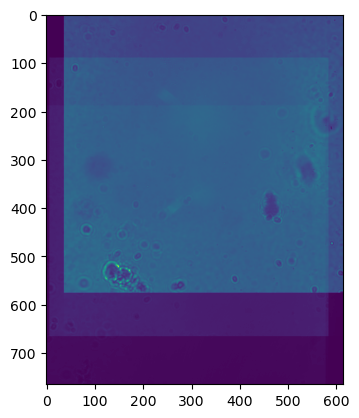

In [216]:
plt.imshow(np.mean(canva,axis=0))

In [36]:
imwrite('../data/drift_new_movie_visual.tif',canva,compression='zlib')

In [218]:
df_drift

,start,end,direction,coord,displacement
0,725,726,1,y,-5
1,726,727,1,y,-1
2,727,728,1,y,-7
3,728,729,1,y,-5
4,729,730,1,y,-9
...,...,...,...,...,...
61,967,968,1,y,0
62,976,977,0,x,5
63,977,978,0,x,0
64,978,979,0,x,-1


## Estimating the error on the canva

Here I'm trying to validate the rescaling of the image. To do so, I tracked a static point on the rescaled image and extracted it's coordinates. From this, I will compute the trajectory: which should be constant, and the local distance (distance between frame t and t+1 which sould be 0.

In [477]:
df_error = pd.read_csv('../data/pos_alg_pipeline.csv')
df_error

,,Label,Mean,X,Y,Slice
0,1,drift_visual.tif:t:725/1039 - drift_visual,25,83.0,435.0,725
1,2,drift_visual.tif:t:726/1039 - drift_visual,25,84.0,433.0,726
2,3,drift_visual.tif:t:727/1039 - drift_visual,25,82.0,427.0,727
3,4,drift_visual.tif:t:728/1039 - drift_visual,22,83.0,429.0,728
4,5,drift_visual.tif:t:729/1039 - drift_visual,24,83.0,427.0,729
...,...,...,...,...,...,...
66,67,drift_visual.tif:t:976/1039 - drift_visual,20,165.0,308.0,976
67,68,drift_visual.tif:t:977/1039 - drift_visual,23,188.0,309.0,977
68,69,drift_visual.tif:t:978/1039 - drift_visual,27,207.0,308.0,978
69,70,drift_visual.tif:t:979/1039 - drift_visual,30,206.0,308.0,979


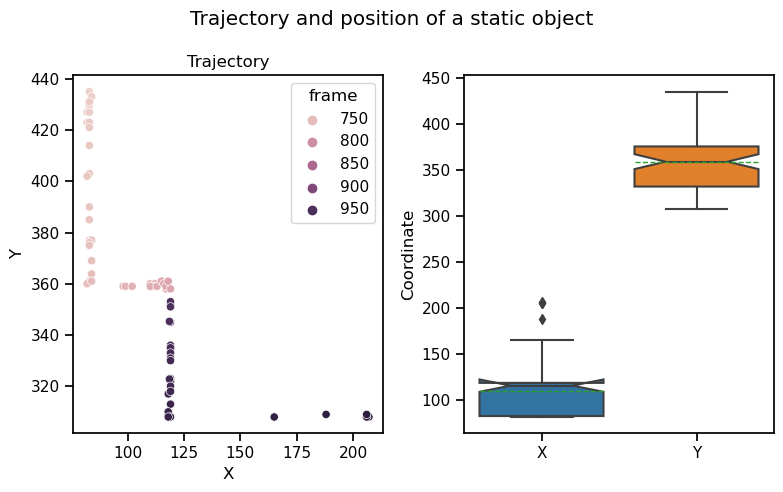

In [481]:
sns.set_context('notebook')
fig,ax = plt.subplots(1,2,figsize=(8,5))

sns.scatterplot(data = df_error,x='X',y='Y',hue='Slice',cmap ='magma',ax=ax[0])
ax[0].legend(title="frame")
ax[0].set_title('Trajectory')

sns.boxplot(data=df_error[["X", "Y"]], meanline=True, showmeans=True,notch=True,ax=ax[1])
ax[1].set_ylabel('Coordinate')

fig.suptitle('Trajectory and position of a static object')
fig.tight_layout()
plt.savefig('../data/results/figures/drift_correction/error_on_full_movie.png',dpi=300)
plt.show()

In [482]:
def eucldistance(df_t,points):
    one = df_t.iloc[points[0]]
    two = df_t.iloc[points[1]]

    diff = (two['X']-one['X'])**2 + (two['Y']-one['Y'])**2
    dist = np.sqrt(diff)
    #print(f'The image moved {dist:.2f} pixels up')
    return dist 

In [484]:
local_dist = []
for i in range(1,max(df_error.index.values)):
    local_dist.append(eucldistance(df_error,[i-1,i]))

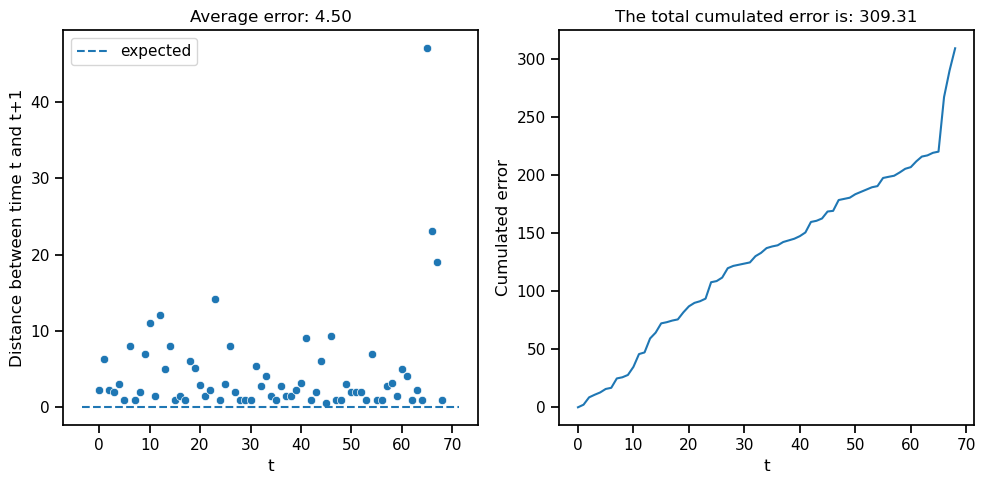

In [485]:
fig,ax = plt.subplots(1,2,figsize=(10,5))

sns.scatterplot(x=[x for x in range(len(local_dist))], y = local_dist,ax=ax[0])
ax[0].set_ylabel('Distance between time t and t+1')
ax[0].set_xlabel('t')
ax[0].hlines(0,ax[0].get_xlim()[0],ax[0].get_xlim()[1],linestyle='--',label='expected')
ax[0].set_title(f'Average error: {np.mean(local_dist):.2f}')
ax[0].legend()

ax[1].plot([x for x in range(len(local_dist))],[sum(local_dist[0:x]) for x in range(len(local_dist)) ])
ax[1].set_ylabel('Cumulated error')
ax[1].set_xlabel('t')
ax[1].set_title(f'The total cumulated error is: {sum(local_dist[0:-1]):.2f}')
plt.tight_layout()
plt.savefig('../data/results/figures/drift_correction/local_cumulated_error.png',dpi=300)


The is a big error on the image. But I want to see whether it comes from the image rescaling or the drift computing. For that I took 1 point in every interval where the pipeline found drift and I will compute the erro on the drift measurement.

In [486]:
def distance(df_t,points):
    one = df_t.iloc[points[0]]
    two = df_t.iloc[points[1]]

    dx = two['X']-one['X']
    dy = two['Y']-one['Y']
    
    return dx,dy

In [490]:
dx = []
dy = []


e = pd.read_csv('../data/pos_alg_true.csv')
e = e[['Y','X','Slice']]
for j in range(1,len(e.index)):
    if e.iloc[j].Slice == e.iloc[j-1].Slice + 1:
        dx.append(distance(e,[j-1,j])[0])
        dy.append(distance(e,[j-1,j])[1])      
         
print(len(dx))

66


In [491]:
dx_rescale = []
dy_rescale = []


e = df_error.copy()
e = e[['Y','X','Slice']]
for j in range(1,len(e.index)):
    if e.iloc[j].Slice == e.iloc[j-1].Slice + 1:
        dx_rescale.append(distance(e,[j-1,j])[0])
        dy_rescale.append(distance(e,[j-1,j])[1])      
         
print(len(dx_rescale))

66


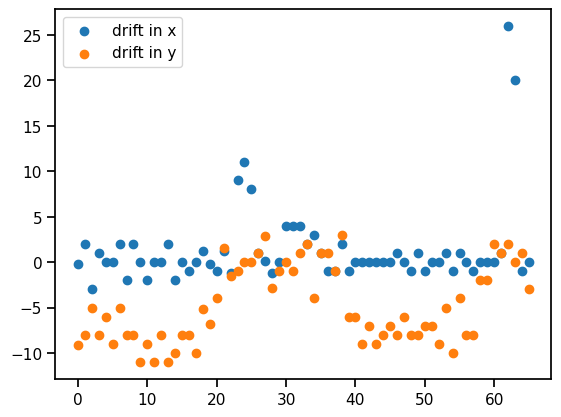

In [492]:
plt.scatter([x for x in range(len(dx))],dx,label="drift in x")
plt.scatter([x for x in range(len(dx))],dy,label="drift in y")
plt.legend()

In [493]:
df_test = df_drift.copy()

In [494]:
error = []
error_resc = []

for j,i in enumerate(df_test.iloc):
    if i.coord == 'y':
        error.append(i.displacement-dy[j])
        error_resc.append(dy_rescale[j])
    else: 
        error.append(i.displacement-dx[j])
        error_resc.append(dx_rescale[j])
        
error

[4.170000000000016,
 7.0,
 -2.0,
 3.0,
 -3.0,
 1.0,
 6.0,
 0.0,
 2.0,
 10.0,
 9.0,
 3.0,
 8.0,
 7.0,
 8.0,
 0.0,
 0.0,
 3.0,
 6.170000000000016,
 5.829999999999984,
 4.0,
 -1.5,
 1.5,
 -1.0,
 -5.0,
 -7.0,
 -1.0,
 -0.1700000000000017,
 2.1700000000000017,
 0.0,
 0.0,
 -4.0,
 -2.0,
 2.0,
 -7.0,
 -1.0,
 1.0,
 1.0,
 -2.0,
 0.0,
 0.0,
 7.0,
 0.0,
 9.0,
 1.0,
 0.0,
 2.0,
 -2.0,
 2.0,
 3.0,
 0.0,
 7.0,
 2.0,
 -2.0,
 5.0,
 0.0,
 1.0,
 6.0,
 2.0,
 2.0,
 -2.0,
 -1.0,
 -21.0,
 -20.0,
 0.0,
 0.0]

In [495]:
df_test['error'] = error
df_test['error_rescale'] = error_resc
df_test['truex'] = dx
df_test['truey'] = dy

In [496]:
df_test

,start,end,direction,coord,displacement,error,error_rescale,truex,truey
0,725,726,1,y,-5,4.17,-2.0,-0.17,-9.17
1,726,727,1,y,-1,7.00,-6.0,2.00,-8.00
2,727,728,1,y,-7,-2.00,2.0,-3.00,-5.00
3,728,729,1,y,-5,3.00,-2.0,1.00,-8.00
4,729,730,1,y,-9,-3.00,3.0,0.00,-6.00
...,...,...,...,...,...,...,...,...,...
61,967,968,1,y,0,-1.00,0.0,1.00,1.00
62,976,977,0,x,5,-21.00,23.0,26.00,2.00
63,977,978,0,x,0,-20.00,19.0,20.00,0.00
64,978,979,0,x,-1,0.00,-1.0,-1.00,1.00


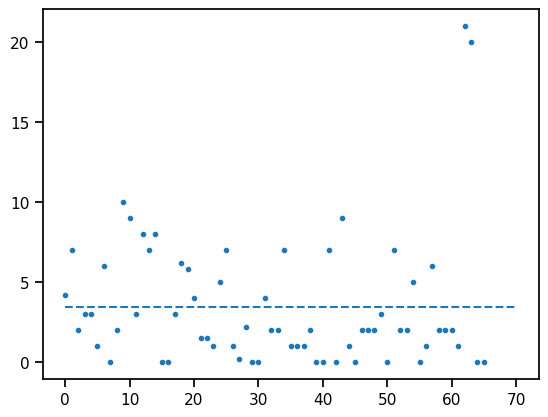

In [500]:
plt.scatter([x for x in range(len(df_test.error.values))],np.abs(df_test.error),marker='.')
plt.hlines(np.mean(np.abs(df_test.error)),0,70,linestyle='--')
plt.savefig('../data/results/figures/drift_correction/drift_measurement_error.png',dpi=300)
plt.show()

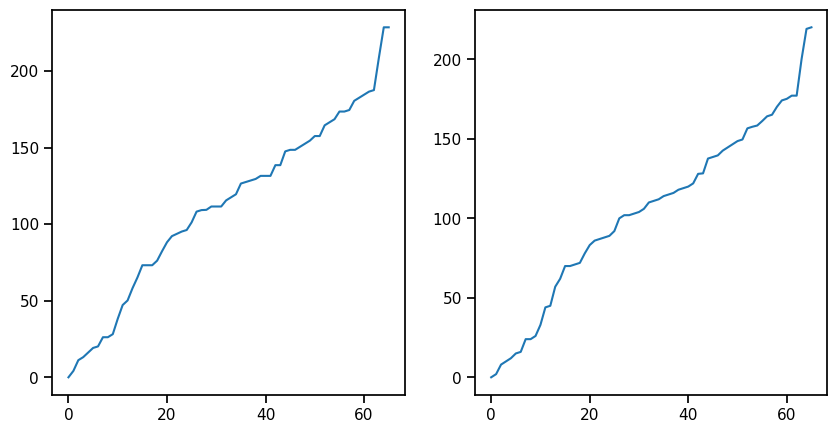

In [498]:
fig,ax = plt.subplots(1,2,figsize=(10,5))

ax[0].plot([sum(np.abs(df_test.error)[0:x]) for x in range(len(np.abs(df_test.error)))])

ax[1].plot([sum(np.abs(df_test.error_rescale)[0:x]) for x in range(len(np.abs(df_test.error_rescale))) ])



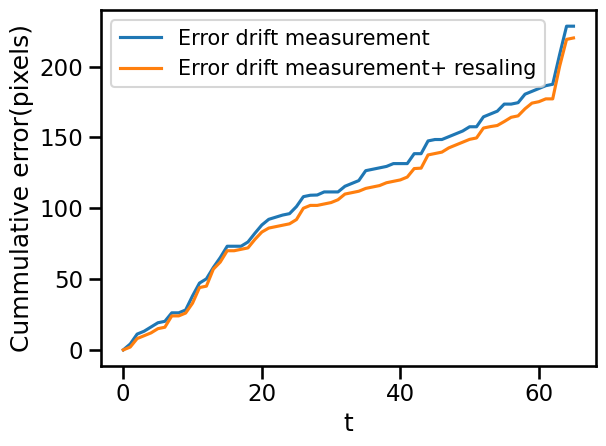

In [509]:
sns.set_context('talk')
plt.plot([sum(np.abs(df_test.error)[0:x]) for x in range(len(np.abs(df_test.error)))],label="Error drift measurement")

plt.plot([sum(np.abs(df_test.error_rescale)[0:x]) for x in range(len(np.abs(df_test.error_rescale))) ],label="Error drift measurement+ resaling")

plt.legend(fontsize='small')
plt.ylabel('Cummulative error(pixels)')
plt.xlabel('t')
plt.tight_layout()
plt.savefig('../data/results/figures/drift_correction/cummulated_error.png',dpi=300)
